In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import plotly.graph_objects as go

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# make df with column names year, month, decimal date, SSN, M1, M2, M3, M4, M5 from file 5c_obs_sim_v1.dat
df = pd.read_csv('5c_obs_sim_v1.dat', sep='\s+', header=None, names=['year', 'month', 'decimal_date', 'SSN', 'M1', 'M2', 'M3', 'M4', 'M5'])

# normalize data to be between 0 and 1 using max value from SSN
M = df['SSN'].max()
df['SSN'] = df['SSN'] / M
for i in range(1, 6):
    df[f'M{i}'] = df[f'M{i}'] / M

df.head()

,year,month,decimal_date,SSN,M1,M2,M3,M4,M5
0,1965,1,1965.042,0.073851,0.0,0.0,0.0,0.004615,0.000511
1,1965,2,1965.123,0.075998,0.0,0.0,0.0,0.005838,0.001198
2,1965,3,1965.204,0.079004,0.0,0.0,0.0,0.007768,0.001380
3,1965,4,1965.288,0.085444,0.0,0.0,0.0,0.010287,0.001755
4,1965,5,1965.371,0.091026,0.0,0.0,0.0,0.013512,0.002240


In [3]:
model_series = df['M1'].values
observed_series = df['SSN'].values

In [4]:
# plot model and observed series via plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['decimal_date'], y=model_series, mode='lines', name='Model Series'))
fig.add_trace(go.Scatter(x=df['decimal_date'], y=observed_series, mode='lines', name='Observed Series'))
fig.update_layout(title='Model and Observed Series', xaxis_title='Decimal Date', yaxis_title='Normalized SSN')
fig.show()

In [5]:
model_series.shape, observed_series.shape

((648,), (648,))

In [6]:
class MixedDataGenerator:
    def __init__(self,
                 model_series,
                 observed_series,
                 previous_values,
                 horizon=18):
        self.model_series = model_series
        self.observed_series = observed_series
        self.horizon = horizon
        self.n_prev = previous_values
        self.X, self.y = self._prepare_data()
        
    def _prepare_data(self):
        l = len(self.model_series) - self.n_prev - self.horizon + 1
        X = np.zeros((l, 2 * self.n_prev + self.horizon))
        y = np.zeros(l)
        for i in range(l):
            X[i, -self.n_prev:] = self.observed_series[i:i + self.n_prev]
            X[i, :-self.n_prev] = self.model_series[i:i + self.n_prev + self.horizon]
            
            # X[i, :self.n_prev] = self.observed_series[i:i + self.n_prev]
            # X[i, self.n_prev:] = self.model_series[i:i + self.n_prev + self.horizon]
            
            y[i] = self.observed_series[i + self.n_prev + self.horizon - 1]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
class NARX(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NARX, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.Sigmoid(),
            *[
                layer
                for i in range(len(hidden_sizes) - 1)
                for layer in (nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]), nn.Sigmoid())
            ],
            nn.Linear(hidden_sizes[-1], output_size),
            nn.Softplus()
        )

    def forward(self, x):
        out = self.net(x)
        return out
    
    def train_model(self, trainloader, valloader, epochs=100, lr=0.001):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        criterion = nn.MSELoss()
        train_losses = []
        val_losses = []
        for i in tqdm(range(epochs), desc='Training', unit='epoch'):
            self.train()
            train_loss = 0
            for X, y in trainloader:
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                output = self(X)
                loss = criterion(output, y.unsqueeze(1))
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            train_losses.append(train_loss / len(trainloader))
            self.eval()
            val_loss = 0
            with torch.no_grad():
                for X, y in valloader:
                    X, y = X.to(device), y.to(device)
                    output = self(X)
                    loss = criterion(output, y.unsqueeze(1))
                    val_loss += loss.item()
                val_losses.append(val_loss / len(valloader))
        
                    
            
        return train_losses, val_losses

In [9]:
data = MixedDataGenerator(model_series, observed_series, 4, 1)

train_data_X = data.X[:250]
train_data_y = data.y[:250]

val_data_X = data.X[250:360]
val_data_y = data.y[250:360]

test_data_X = data.X[360:]
test_data_y = data.y[360:]

trainloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_data_X, train_data_y),
    batch_size=64,
    shuffle=True
)
valloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(val_data_X, val_data_y),
    batch_size=64,
    shuffle=False
)

In [14]:
model = NARX(input_size=9,
             hidden_sizes=[24],
             output_size=1)
model.to(device)


NARX(
  (net): Sequential(
    (0): Linear(in_features=9, out_features=24, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=24, out_features=1, bias=True)
    (3): Softplus(beta=1, threshold=20)
  )
)

In [15]:
train_losses, val_losses = model.train_model(trainloader, valloader, epochs=2000, lr=0.001)

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(train_losses)), y=train_losses, mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=np.arange(len(val_losses)), y=val_losses, mode='lines', name='Val Loss'))
fig.update_layout(title='Train and Val Losses', xaxis_title='Epoch', yaxis_title='MSE Loss')
fig.show()


Training: 100%|██████████| 2000/2000 [00:27<00:00, 73.16epoch/s]


In [17]:
model.eval()
x = data.X.to(device)
y = data.y.to(device)
preds = model(x.to(device)).squeeze(1)

fig = go.Figure()
fig.add_trace(go.Scatter(y=y.cpu().numpy() * M, name='True', mode='lines', line=dict(color='green')))
fig.add_trace(go.Scatter(y=preds.detach().cpu().numpy() * M, name='Predicted', mode='lines', line=dict(color='red')))
# train-val line
# fig.add_shape(type='line', x0=(1 - test_val_size) * len(x), x1=(1 - test_val_size) * len(x), y0=0, y1=1, line=dict(color='gray', width=1, dash='dash'))
fig.add_shape(type='line', x0=0.8 * len(x), x1=0.8 * len(x), y0=0, y1=1, line=dict(color='gray', width=1, dash='dash'))
# add M1
fig.add_trace(go.Scatter(y=model_series * M, name='M1', mode='lines', line=dict(color='blue', dash='dash', width=1)))
fig.update_layout(title=f'Results. Rmse: {((y - preds) ** 2).mean().sqrt().item() * M:.4f}', xaxis_title='Time', yaxis_title='Value')
fig.show()


In [32]:
# make preds for test data
test_data_X = test_data_X.to(device)
test_data_y = test_data_y.to(device)
preds = model(test_data_X).squeeze()
preds.shape


torch.Size([284])

In [ ]:
rmses = (preds - test_data_y).pow(2).mean(dim=0).sqrt() * M

for i, rmse in enumerate(rmses):
    print(f'RMSE for step {i + 1}: {rmse.item():.2f}')

In [ ]:
preds.squeeze()

In [34]:
rmses = []
predictions = []
test_val_size = 0.6
val_size = 0.7
for horizon in tqdm(range(1, 19), desc='Horizons'):
    n_prev = 4
    data = MixedDataGenerator(model_series,
                            observed_series,
                            n_prev,
                            horizon)
    train_data_X = data.X[:250]
    train_data_y = data.y[:250]

    val_data_X = data.X[250:360]
    val_data_y = data.y[250:360]

    test_data_X = data.X[360:]
    test_data_y = data.y[360:]
    trainloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(train_data_X, train_data_y),
        batch_size=64,
        shuffle=True
    )
    valloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(val_data_X, val_data_y),
        batch_size=64,
        shuffle=False
    )
    model = NARX(input_size=2*n_prev + horizon,
             hidden_sizes=[24],
             output_size=1)
    model.to(device)
    train_losses, val_losses = model.train_model(trainloader, valloader, epochs=2000, lr=0.001)
    model.eval()
    x = test_data_X.to(device)
    y = test_data_y.to(device).squeeze()
    prediction = model(x.to(device)).squeeze()
    predictions.append(prediction)
    rmse = torch.sqrt(torch.mean((prediction * M - y * M) ** 2))
    print(f'Rmse for horizon {horizon}: {rmse}')
    rmses.append(rmse.item())
    # save
    torch.save(model.state_dict(), f'models_x18/{horizon}_horizon.pth')

Horizons:   6%|▌         | 1/18 [00:28<08:12, 28.99s/it]

Rmse for horizon 1: 4.904375076293945


Horizons:  11%|█         | 2/18 [00:58<07:46, 29.16s/it]

Rmse for horizon 2: 6.641359806060791


Horizons:  17%|█▋        | 3/18 [01:27<07:18, 29.20s/it]

Rmse for horizon 3: 8.218338012695312


Horizons:  22%|██▏       | 4/18 [01:57<06:53, 29.51s/it]

Rmse for horizon 4: 9.250991821289062


Horizons:  28%|██▊       | 5/18 [02:27<06:26, 29.71s/it]

Rmse for horizon 5: 11.36028003692627


Horizons:  33%|███▎      | 6/18 [02:56<05:55, 29.59s/it]

Rmse for horizon 6: 12.474519729614258


Horizons:  39%|███▉      | 7/18 [03:25<05:23, 29.36s/it]

Rmse for horizon 7: 13.81508731842041


Horizons:  44%|████▍     | 8/18 [03:55<04:55, 29.57s/it]

Rmse for horizon 8: 15.489895820617676


Horizons:  50%|█████     | 9/18 [04:26<04:27, 29.77s/it]

Rmse for horizon 9: 16.091175079345703


Horizons:  56%|█████▌    | 10/18 [04:56<03:58, 29.85s/it]

Rmse for horizon 10: 17.456846237182617


Horizons:  61%|██████    | 11/18 [05:26<03:30, 30.01s/it]

Rmse for horizon 11: 18.4551944732666


Horizons:  67%|██████▋   | 12/18 [05:57<03:02, 30.41s/it]

Rmse for horizon 12: 19.086774826049805


Horizons:  72%|███████▏  | 13/18 [06:28<02:32, 30.56s/it]

Rmse for horizon 13: 19.819103240966797


Horizons:  78%|███████▊  | 14/18 [06:58<02:01, 30.47s/it]

Rmse for horizon 14: 20.340871810913086


Horizons:  83%|████████▎ | 15/18 [07:29<01:31, 30.58s/it]

Rmse for horizon 15: 20.63497543334961


Horizons:  89%|████████▉ | 16/18 [07:59<01:00, 30.36s/it]

Rmse for horizon 16: 21.226337432861328


Horizons:  94%|█████████▍| 17/18 [08:29<00:30, 30.09s/it]

Rmse for horizon 17: 22.339635848999023


Horizons: 100%|██████████| 18/18 [08:58<00:00, 29.92s/it]

Rmse for horizon 18: 21.740171432495117


In [36]:
np.array(rmses)

array([ 4.90437508,  6.64135981,  8.21833801,  9.25099182, 11.36028004,
       12.47451973, 13.81508732, 15.48989582, 16.09117508, 17.45684624,
       18.45519447, 19.08677483, 19.81910324, 20.34087181, 20.63497543,
       21.22633743, 22.33963585, 21.74017143])

In [39]:
for p in predictions:
    print(p.shape)

torch.Size([284])
torch.Size([283])
torch.Size([282])
torch.Size([281])
torch.Size([280])
torch.Size([279])
torch.Size([278])
torch.Size([277])
torch.Size([276])
torch.Size([275])
torch.Size([274])
torch.Size([273])
torch.Size([272])
torch.Size([271])
torch.Size([270])
torch.Size([269])
torch.Size([268])
torch.Size([267])


In [58]:
mp = min([p.shape for p in predictions])[0]
preds = np.array([x[:mp].detach().cpu().numpy() for x in predictions]).T
preds.shape

(267, 18)

In [63]:
data = MixedDataGenerator(model_series, observed_series, 4, 1)


In [70]:
for i, rmse in enumerate(rmses):
    print(f'RMSE for step {i + 1}: {rmse:.2f}')

RMSE for step 1: 4.90
RMSE for step 2: 6.64
RMSE for step 3: 8.22
RMSE for step 4: 9.25
RMSE for step 5: 11.36
RMSE for step 6: 12.47
RMSE for step 7: 13.82
RMSE for step 8: 15.49
RMSE for step 9: 16.09
RMSE for step 10: 17.46
RMSE for step 11: 18.46
RMSE for step 12: 19.09
RMSE for step 13: 19.82
RMSE for step 14: 20.34
RMSE for step 15: 20.63
RMSE for step 16: 21.23
RMSE for step 17: 22.34
RMSE for step 18: 21.74


In [67]:
def plot_pred(start, folder_name):
    preds_auto = preds[start]

    # plot autoregressive prediction
    plt.figure(figsize=(15, 5))
    plt.plot(data.y.detach().cpu()[360:]* M, label='True', color='green')

    # X axis for preds_auto and model_series
    x_range = range(start, start + len(preds_auto))  # Для preds_auto

    # Plot preds_auto and model_series from start
    plt.plot(x_range, preds_auto * M, label='Predicted', color='red')
    plt.plot(model_series[360:] * M, label='M1', linestyle='--', color='blue', alpha=0.5)

    plt.title('Autoregressive prediction')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'results/{folder_name}/ex_{start}.png')
    plt.show()

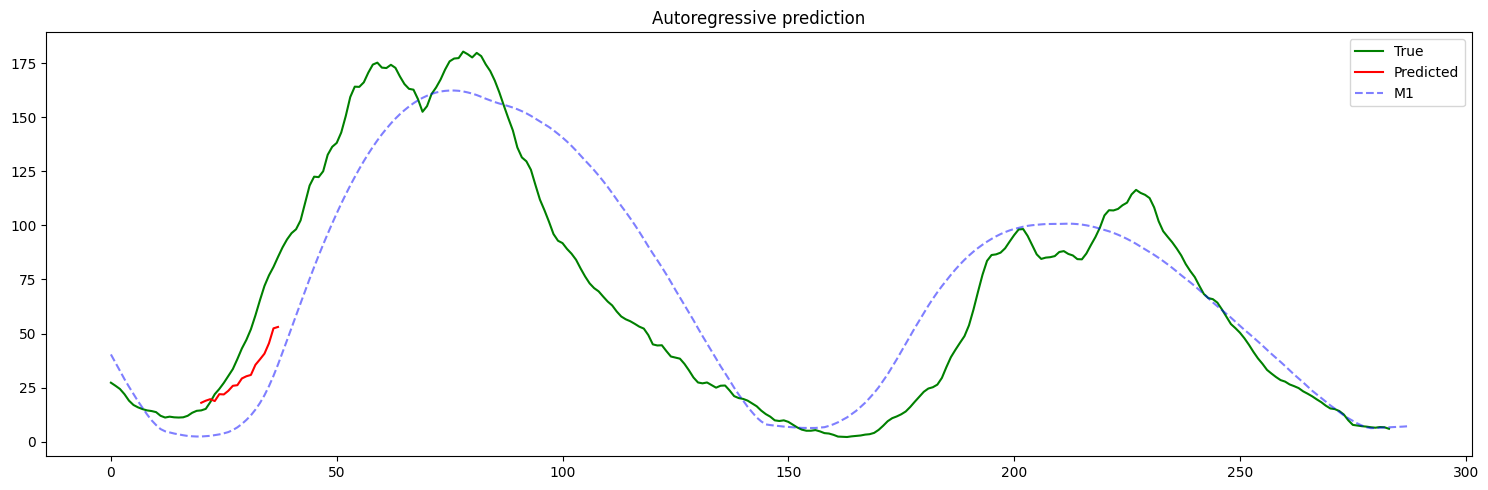

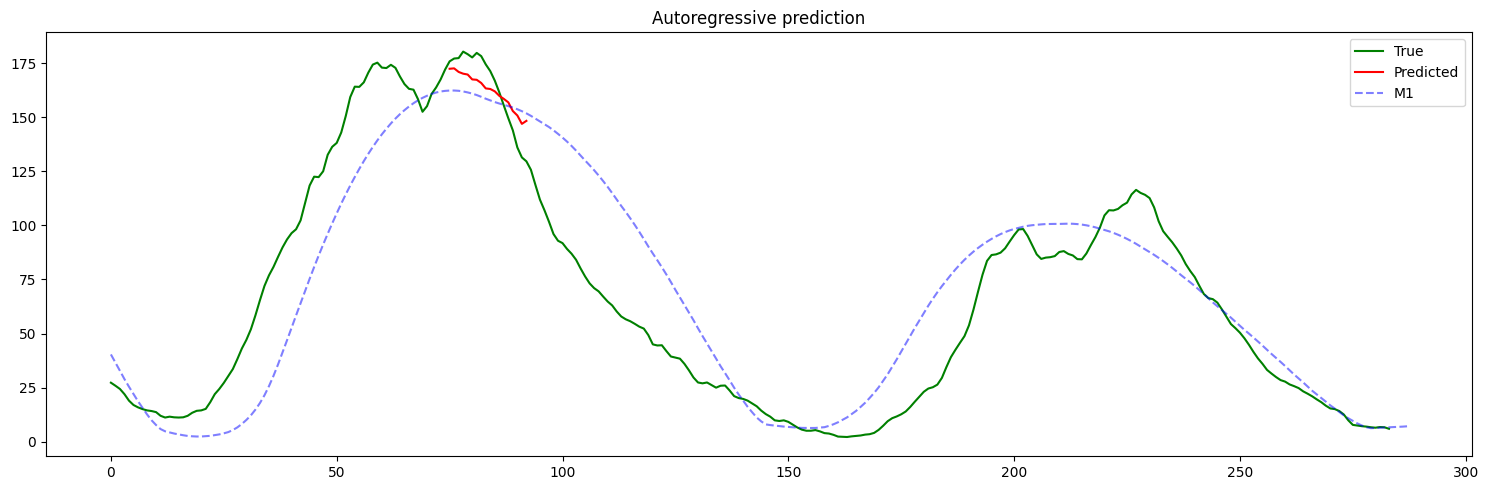

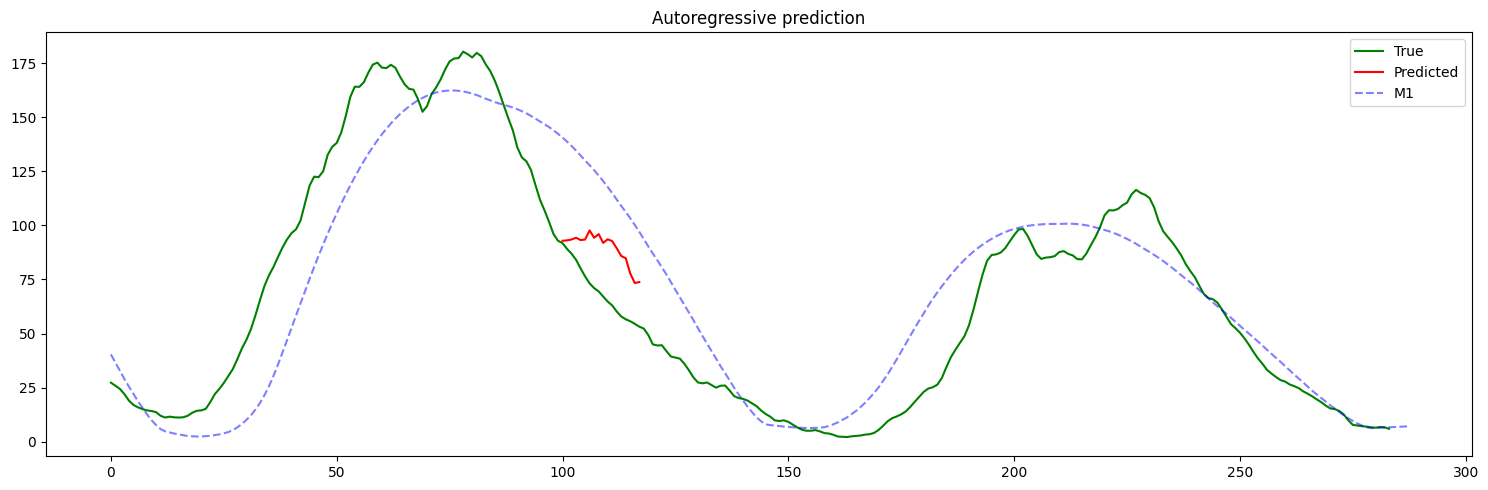

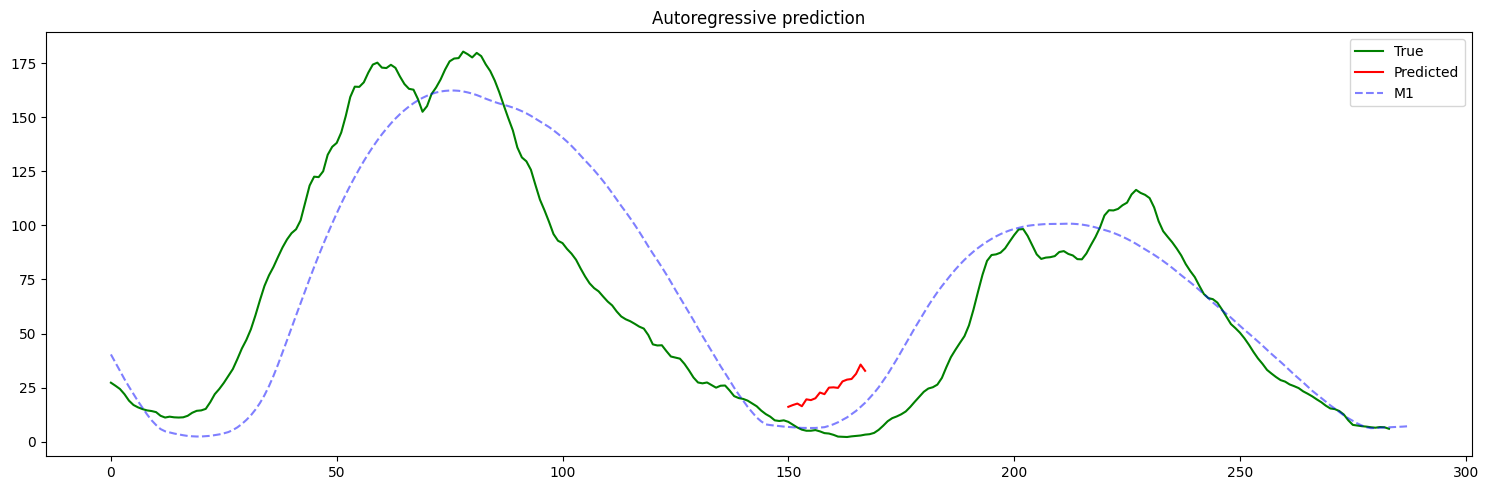

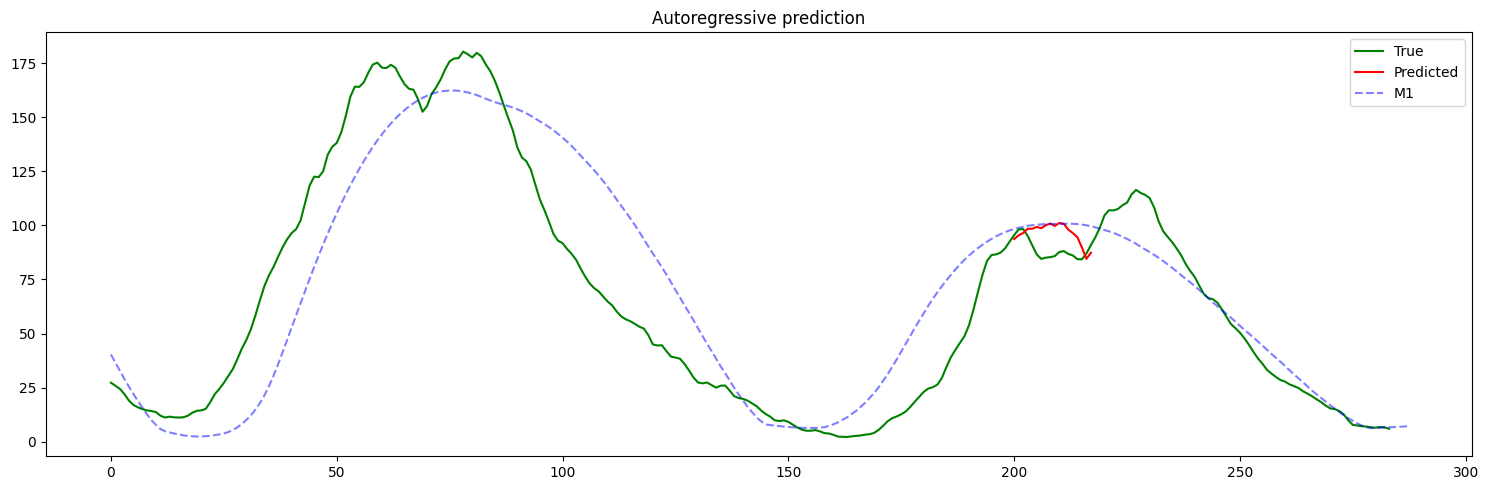

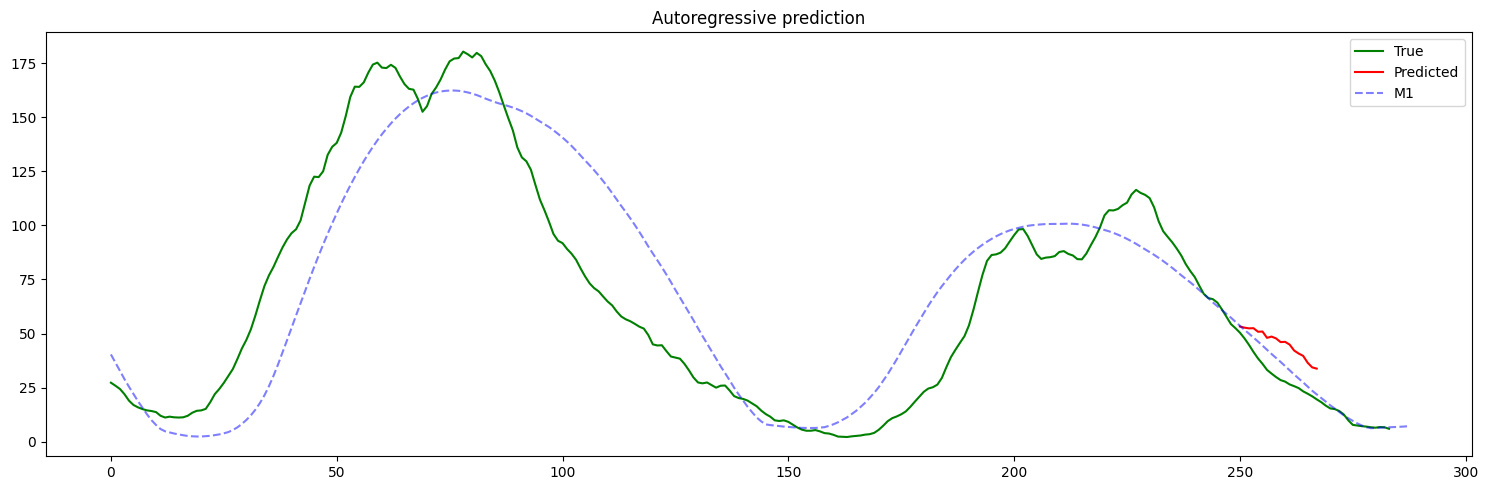

In [68]:
for s in [20, 75, 100, 150, 200, 250]:
    plot_pred(s, 'x18')